# fit_us_data.ipynb

Fit various functions to COVID-19 time series for U.S. counties using the Broyden–Fletcher–Goldfarb–Shanno solver from `sklearn.optimize`.

Inputs:
* `outputs/us_counties_clean.feather`: The contents of `data/us_counties.csv` after data cleaning by [clean_us_data.ipynb](./clean_us_data.ipynb)

Outputs:
* `outputs/us_counties_curves.csv`: The curves that this notebook generated
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input and output files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics
from typing import Any, Tuple


import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# What precision of floating-point to use.
# Consider 32-bit if using GPU-accelerated solvers. Otherwise, 64-bit
# floating point is better because it reduces the chance of divergence.
fp_type = np.float64

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Load time series data

In [2]:
# Read time series data from the binary file that clean_us_data.ipynb produces
dates_file = os.path.join(_OUTPUTS_DIR, "dates.feather")
cases_file = os.path.join(_OUTPUTS_DIR, "us_counties_clean.feather")
cases = pd.read_feather(cases_file).set_index("FIPS")
dates = pd.read_feather(dates_file)["date"].to_numpy()
cases.head()

,State,County,Population,Confirmed,Deaths,Recovered,Confirmed_Outlier,Deaths_Outlier,Recovered_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",124,8
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",319,9
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,3
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,2
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[ 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,3


In [3]:
# To simplify the code that follows, we only fit curves to one of
# the time series for each county. 
# Change the following constant to use a different time series:
ts_col_name = "Confirmed"

## Aliasing in time series for sparsely-populated counties

Because these time series are integer-valued, there can be problems with aliasing. 
Here are some examples of what aliasing looks like (The `graph_examples()` function is defined in [util.py](./util.py))

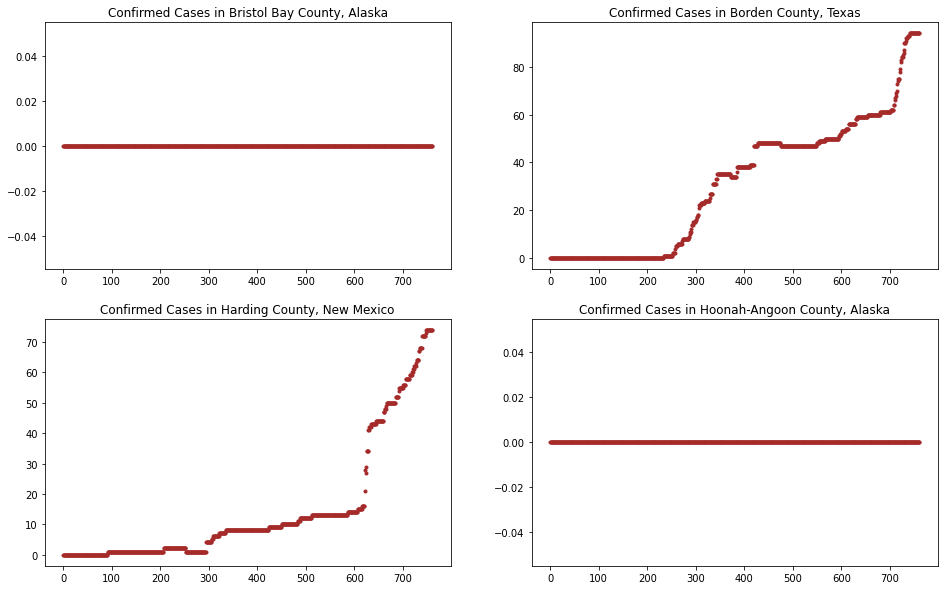

In [4]:
alias_threshold = 100
util.graph_examples(cases, ts_col_name, {},
                    mask=(np.max(cases[ts_col_name].array, axis=1).to_numpy() < alias_threshold))

## Filter time series that are subject to aliasing

To avoid problems due to aliasing, we will restrict the analysis
in the rest of this notebook to time series whose maximum values
go above a threshold.

In [5]:
# We also cut off the sections at the beginning of the time 
# series where every time series' value is below this threshold.

# Find what point in the time series at least one county went above
# the threshold.
first_time_above_min = np.argmax(np.max(cases[ts_col_name].array, axis=0) >= alias_threshold)
print(f"Dropping the first {first_time_above_min} elements of each time series.")

# Find which counties have at least one time series value above the 
# threshold.
counties_mask = np.max(cases[ts_col_name].array, axis=1).to_numpy() >= alias_threshold

# Filter rows
filtered = cases[counties_mask].copy(deep=True)

# Truncate time series to just the times when at least one county
# was above our threshold.
filtered[ts_col_name] = filtered[ts_col_name].array[:, first_time_above_min:]

# Also filter the outlier masks
outlier_col_name = ts_col_name + "_Outlier"
filtered[outlier_col_name] = filtered[outlier_col_name].array[:, first_time_above_min:]

filtered_dates = dates[first_time_above_min:]

# Drop time series columns other than the one we analyze
series_to_keep = [ts_col_name, outlier_col_name]
metadata_cols = []
to_drop = []
for colname in filtered.columns:
    if not isinstance(filtered[colname].dtype, tp.TensorDtype):
        metadata_cols.append(colname)
    elif colname not in series_to_keep:
        to_drop.append(colname)

filtered = filtered.drop(columns=to_drop)

filtered

Dropping the first 48 elements of each time series.


,State,County,Population,Confirmed,Confirmed_Outlier,Confirmed_7_Days,Deaths_7_Days
FIPS,,,,,,,
1001,Alabama,Autauga,55869,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",124,8
1003,Alabama,Baldwin,223234,"[ 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",319,9
1005,Alabama,Barbour,24686,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20,3
1007,Alabama,Bibb,22394,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",40,2
1009,Alabama,Blount,57826,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",116,3
...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",120,3
56039,Wyoming,Teton,23464,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",114,0
56041,Wyoming,Uinta,20226,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,0


# Warm-up: Fit a straight line

We use sklearn's implementation of [BGFS](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) as the optimizer.

First we fire up [Ray](https://ray.io/) so that we can fit multiple curves at the same time.

In [6]:
import ray
if not ray.is_initialized():
    ray.init()

In [7]:
# What precision of floating-point to use
# On a laptop, there's not much reason to use 32-bit.
fp_type = np.float64
series_values = filtered[ts_col_name].array.astype(fp_type)
series_len = series_values.shape[1]
x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)


def linear_curve(m, b):
    return m * x + b


def linear_objective(var_values, y):
    m, b = var_values
    return np.sum((y - (linear_curve(m, b))) ** 2)


linear_initial_guess = (0.1, 1.0)
linear_bounds = ((0.0, 1000.0), (float(-series_len), float(series_len)))


# Fit all the curves in parallel
@ray.remote
def fit_line(points: np.array):
    return scipy.optimize.minimize(
        linear_objective, linear_initial_guess,
        args=(points), bounds=linear_bounds)


futures = [fit_line.remote(ts) for ts in series_values]

# Wrap results in a DataFrame
linear = filtered[metadata_cols].copy()
linear["Result_Object"] = ray.get(futures)
linear["Slope"] = linear["Result_Object"].apply(lambda r: r.x[0])
linear["Intercept"] = linear["Result_Object"].apply(lambda r: r.x[1])

# Generate all the linear curves
M = linear["Slope"].values.reshape([-1, 1])
X = x.reshape([1, -1])
B = linear["Intercept"].values.reshape([-1, 1])
linear["Curve"] = tp.TensorArray(M * X + B)

# Compute coefficient of determination
linear["R^2"] = [
    metrics.r2_score(
        filtered.loc[fips][ts_col_name], linear.loc[fips]["Curve"]) 
        for fips in filtered.index]

linear

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Slope,Intercept,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"{'fun': 561672783.9484109, 'jac': [11.92092796...",18.106313,-713.000000,"[ -713.0, -694.8936871371611, ...",0.954607
1003,Alabama,Baldwin,223234,319,9,"{'fun': 15017980987.965172, 'jac': [381.469694...",59.186422,-713.000000,"[ -713.0, -653.813578042312, ...",0.909613
1005,Alabama,Barbour,24686,20,3,"{'fun': 59496317.799230106, 'jac': [-33.527612...",6.747312,-424.796609,"[ -424.79660922319556, -418.0492969678975, ...",0.958529
1007,Alabama,Bibb,22394,40,2,"{'fun': 98073231.90261063, 'jac': [657.1411542...",8.176874,-690.983186,"[ -690.9831863926179, -682.8063121400476, ...",0.953688
1009,Alabama,Blount,57826,116,3,"{'fun': 550481687.0544053, 'jac': [0.0, 332414...",17.954927,-713.000000,"[ -713.0, -695.0450730262263, ...",0.955514
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"{'fun': 542810650.6622834, 'jac': [0.0, 336289...",12.863669,-713.000000,"[ -713.0, -700.1363306928132, ...",0.922913
56039,Wyoming,Teton,23464,114,0,"{'fun': 432518195.8628566, 'jac': [0.0, 136065...",10.522281,-713.000000,"[ -713.0, -702.4777190278324, ...",0.898945
56041,Wyoming,Uinta,20226,30,0,"{'fun': 95303555.57333985, 'jac': [0.0, 5015.7...",7.348945,-713.000000,"[ -713.0, -705.6510553203026, ...",0.945219


## Graph: Example linear curves

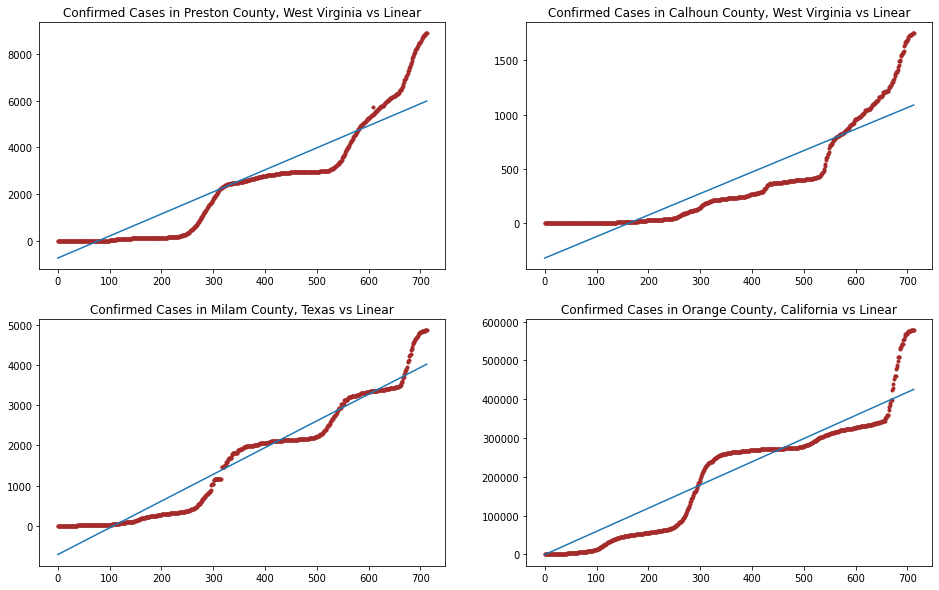

In [8]:
# Plot the lines we just fit, using the graph_examples() function in util.py.
util.graph_examples(filtered, ts_col_name, {"Linear": linear})

# Define code for fitting any curve

As you can see from the above graphs, straight lines do not explain the data in most of these time series.
Let's fit some more appropriate curves to this data, using the same BGFS optimizer.
First, we'll break out the repetitive parts of the curve-fitting process into a Python function.

In [9]:
def curve_fit_df(df: pd.DataFrame, ts_col_name: str,
                 curve_fn,
                 param_names: Tuple,
                 initial_guess: Tuple,
                 bounds: Tuple,
                 regularize_fn: Any = None):
    """
    Fit a curve to a column full of time series.

    :param df: DataFrame containing one time series per cell
    :param ts_col_name: Column containing the time series to analyze
    :param curve_fn: Function that, if called with a vector of X values
     and a tuple of parameters, will compute the value of the curve 
     being fit.
     If parameters are vectors, this function must compute multiple
     curves, one for each element of the vectors.

    :param param_names: Names of the parameters of `curve_fn`.
    :param initial_guess: Initial values for the paramters to start
     off the solver.
    :param bounds: Lower and upper bounds for the parameters.
    :param regularize_fn: Optional function that returns a 
     regularization penalty, given a set of parameter values.

    :returns: A dataframe with one row per row of `df`, containing
     information about the 
    """
    series_values = df[ts_col_name].array.astype(fp_type)
    series_len = series_values.shape[1]
    x = np.linspace(0, series_len - 1, series_len, dtype=fp_type)
    
    def return_zero(var_values):
        return 0.0
    
    if regularize_fn is None:
        regularize_fn = return_zero
    
    def objective(var_values, y):
        squared_diffs = np.sum((y - (curve_fn(x, var_values))) ** 2)
        return squared_diffs + regularize_fn(var_values)
    
    # Fit the curve to all time series in parallel
    @ray.remote
    def fit_curve(points: np.array):
        return scipy.optimize.minimize(
            objective, initial_guess,
            args=(points), bounds=bounds)
    futures = [fit_curve.remote(ts) for ts in series_values]
    
    # Wrap the results in a DataFrame
    result = pd.DataFrame(index=df.index)
    result[metadata_cols] = df[metadata_cols]
    result["Result_Object"] = ray.get(futures)
    
    # Add a column for each parameter
    for i in range(len(param_names)):
        name = param_names[i]
        result[name] = result["Result_Object"].apply(lambda r: r.x[i])

    # Generate all the curves
    param_vectors = [
        result[name].values.reshape([-1, 1])
        for name in param_names
    ]
    result["Curve"] = tp.TensorArray(curve_fn(x, param_vectors))

    # Compute coefficient of determination
    result["R^2"] = [
        metrics.r2_score(
            df.loc[fips][ts_col_name], result.loc[fips]["Curve"]) 
            for fips in df.index]

    return result

In [10]:
# Define curve-fitting routines using the function from the previous
# cell.

def fit_exponential(ts_col_name: str):
    """
    Fit an exponential curve to each time series in the specified column
    of the `cases` dataframe.
    """
    def curve_fn(x, var_values):
        rate, offset = var_values
        # Y = e^(rate * (X - offset))
        return np.exp(rate * (x - offset))
    
    param_names = ("Rate", "Offset")
    initial_guess = (0.1, 1.0)
    bounds = ((0.001, 1.0), (0.0, float(len(filtered_dates))))

    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic(ts_col_name: str):
    """
    Fit a logistic curve to each time series in the specified column
    of the `cases` dataframe.
    """
    def curve_fn(x, var_values):
        max_, rate, offset = var_values
        # Y = max / (1 + e^(-rate *(X - offset))
        return max_ / (1.0 + np.exp(-rate * (x - offset)))

    param_names = ("Max", "Rate", "Offset")
    initial_guess = (1000.0, 0.1, 1.0)
    bounds = ((0.0, 1e6), (0.0, 1.0), (0.0, float(len(filtered_dates))))

    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds)


def fit_logistic2(ts_col_name: str):
    """
    Fit a mixture of two logistic curves to each time series in the 
    specified column of the `cases` dataframe.
    """
    # Distance from X=0 at which the logistic function is close enough to 0 or 1
    # that we can consider it to have "triggered"
    logistic2_limit = np.array(6., dtype=fp_type)

    def curve_fn(x, var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values

        # logistic curve is Y = max / (1 + e^(-rate *(X - offset))
        logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
        logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))

        # What fraction of the output comes from logistic2?
        def sigmoid(x_):
            return 1. / (1. + np.exp(-x_))

        mix_input = (x - switch_begin - logistic2_limit) / np.maximum(1.0, (switch_end - switch_begin))
        return logistic1 * (1.0 - sigmoid(mix_input)) + logistic2 * sigmoid(mix_input)

    def regularize_fn(var_values):
        (max1, rate1, offset1, 
         max2, rate2, offset2, 
         switch_begin, switch_end) = var_values
        reg_coeff = 1e7
        linear_terms = [
            max(0.0, switch_begin - switch_end - 1.0)  # switch_end >= switch_begin + 1
        ]
        return reg_coeff * sum([t for t in linear_terms])

    param_names = (
        "Max1", "Rate1", "Offset1",
        "Max2", "Rate2", "Offset2",
        "Switch_Begin", "Switch_End")
    initial_guess = (
        1000.0, 0.1, 1.0,  # First logistic function
        1000.0, 0.1, 1.0,  # Second logistic function
        10.0, 20.0  # Switchover
    )
    series_len = len(filtered_dates)
    bounds = (
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # First logistic function
        (0.0, 1e6), (0.0, 10.0), (0.0, float(series_len)),   # Second logistic function
        (0.0, float(series_len)), (0.0, float(series_len))  # Switchover
    )

    return curve_fit_df(filtered, ts_col_name, curve_fn,
                        param_names, initial_guess, bounds,
                        regularize_fn=regularize_fn)


# Fit exponential curves

In [11]:
%%time
exp_df = fit_exponential(ts_col_name)
exp_df

(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:12: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/1416552647.py:39: RuntimeWarning: overflow encountered in square
(fit_curve pid=26508) /Users/freiss/pd/cn-maintain/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
(fit_curve pid=26508)   df = fun(x) - f0
(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:12: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/1416552647.py:39: RuntimeWarning: overflow encountered in square
(fit_curve pid=26517) /Users/freiss/pd/cn-maintain/env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
(fit_curve pid=2651

CPU times: user 4.81 s, sys: 1.02 s, total: 5.83 s
Wall time: 4.76 s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"{'fun': 34098814719.738197, 'jac': [-700160942...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.755806
1003,Alabama,Baldwin,223234,319,9,"{'fun': 417859506015.7572, 'jac': [-2450419921...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.514923
1005,Alabama,Barbour,24686,20,3,"{'fun': 4217411081.809073, 'jac': [-2464856672...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.939701
1007,Alabama,Bibb,22394,40,2,"{'fun': 5626210874.9744215, 'jac': [-284270849...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.656816
1009,Alabama,Blount,57826,116,3,"{'fun': 33506692313.126755, 'jac': [-694164428...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.707772
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"{'fun': 16431001447.17487, 'jac': [-4843914413...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.333452
56039,Wyoming,Teton,23464,114,0,"{'fun': 10425386855.92163, 'jac': [-3832295608...",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.435824
56041,Wyoming,Uinta,20226,30,0,"{'fun': 4308260666.07504, 'jac': [-2483954715....",0.001,0.000000e+00,"[ 1.0, 1.0010005001667084, 1.002...",-1.476400


## Graph: Example exponential curves

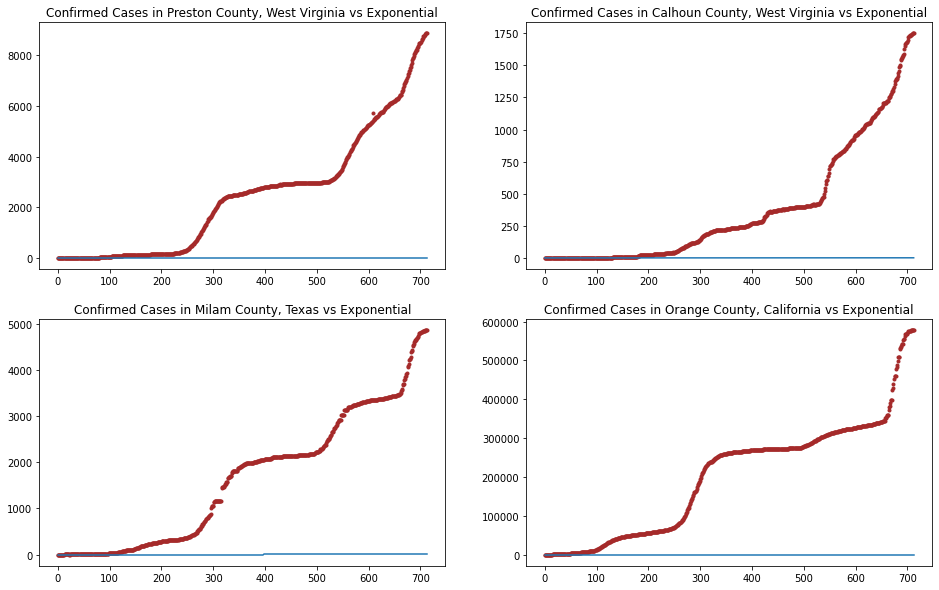

In [12]:
util.graph_examples(filtered, ts_col_name, {"Exponential": exp_df})

# Fit logistic curves

The [logistic function](https://en.wikipedia.org/wiki/Logistic_function) produces an "S"-shaped curve 
that often closely matches one wave of a disease outbreak.

In [13]:
%%time
log_df = fit_logistic(ts_col_name)
log_df

(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26513) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26512) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26511) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26519) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26518) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26506) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26521) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26516) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26507) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26510) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26520) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: R

(fit_curve pid=26514) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26515) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26509) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:30: RuntimeWarning: overflow encountered in exp


CPU times: user 5.21 s, sys: 1.15 s, total: 6.36 s
Wall time: 13.5 s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max,Rate,Offset,Curve,R^2
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"{'fun': 546385118.0128577, 'jac': [0.0, 478124...",15179.713386,0.006721,468.457363,"[ 624.6331894752971, 628.6710725690873, 632....",0.955842
1003,Alabama,Baldwin,223234,319,9,"{'fun': 5848631097.428328, 'jac': [0.0, -69486...",68013.984324,0.006186,560.283844,"[2060.7612874244896, 2073.158727058375, 2085...",0.964800
1005,Alabama,Barbour,24686,20,3,"{'fun': 854796082.2291765, 'jac': [1096.737062...",2770.948678,0.003967,2.326799,"[1379.0803011728278, 1381.8282813341243, 1384....",0.404174
1007,Alabama,Bibb,22394,40,2,"{'fun': 99621179.43480033, 'jac': [0.0, -43306...",7724.076583,0.005851,554.305266,"[290.18903826648176, 291.8275900300823, 293.4...",0.952957
1009,Alabama,Blount,57826,116,3,"{'fun': 528493182.04531544, 'jac': [-17.879956...",15085.899997,0.006791,469.858542,"[ 595.9804081930149, 599.8802336825881, 603....",0.957291
...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"{'fun': 4638962240.69805, 'jac': [4768.4220100...",5220.855522,0.003887,4.113539,"[ 2589.560912294687, 2594.633492819649, 2599...",0.341197
56039,Wyoming,Teton,23464,114,0,"{'fun': 2810470770.209529, 'jac': [2861.053206...",4184.771657,0.003919,3.360202,"[ 2078.609359356614, 2082.7091822119874, 2086...",0.343352
56041,Wyoming,Uinta,20226,30,0,"{'fun': 77441755.14777043, 'jac': [0.0, -10041...",7384.003627,0.005951,584.638181,"[ 220.8006252837378, 222.07899021650775, 223.3...",0.955486


## Graph: Example logistic curves

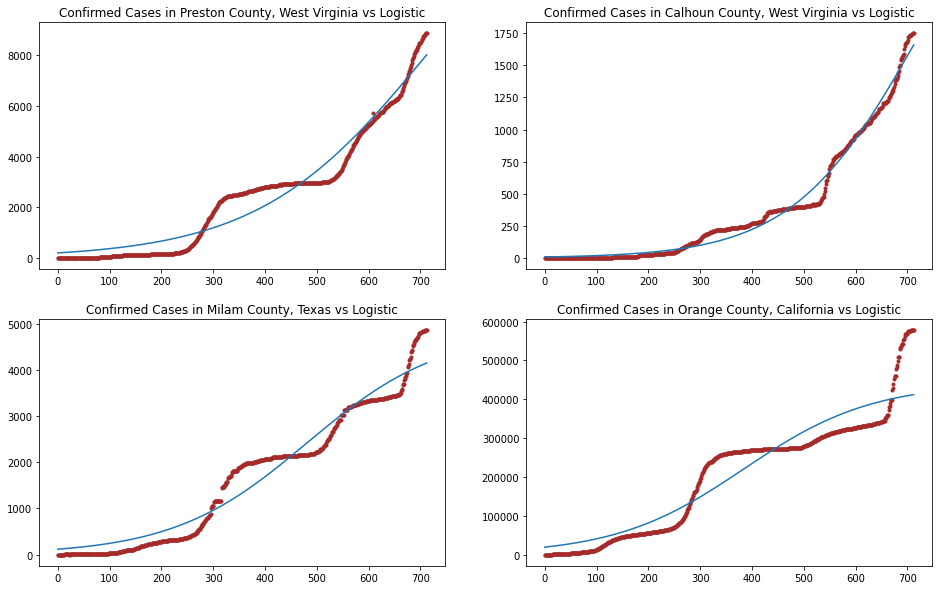

In [14]:
util.graph_examples(filtered, ts_col_name, {"Logistic": log_df})

# Fit a mixture of two logistic curves

A mixture of two logistic curves with different starting points can explain the data for disease
outbreaks involving two distinct waves.

In [15]:
%%time
log2_df = fit_logistic2(ts_col_name)
log2_df

(fit_curve pid=26514) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26506) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26520) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26518) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26518) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26514) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26509) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: R

(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26509) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26519) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26512) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: R

(fit_curve pid=26511) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26510) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26506) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26518) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26510) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26519) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26519) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: R

(fit_curve pid=26517) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26516) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26516) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26512) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26508) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26514) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26510) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: R

(fit_curve pid=26507) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26511) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26515) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26521) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26507) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26520) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26521) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26513) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26521) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26513) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
(fit_curve pid=26515) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26520) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:60: RuntimeWarning: overflow encountered in exp


(fit_curve pid=26511) /var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp


/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:55: RuntimeWarning: overflow encountered in exp
  logistic1 = max1 / (1.0 + np.exp(-rate1 * (x - offset1)))
/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/3467729293.py:56: RuntimeWarning: overflow encountered in exp
  logistic2 = max2 / (1.0 + np.exp(-rate2 * (x - offset2)))


CPU times: user 7.36 s, sys: 2.51 s, total: 9.87 s
Wall time: 1min 10s


,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Result_Object,Max1,Rate1,Offset1,Max2,Rate2,Offset2,Switch_Begin,Switch_End,Curve,R^2
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"{'fun': 521118631.95597327, 'jac': [40221.1823...",987.876708,0.000000,7.710577,15913.608256,0.008568,261.268712,4.154896e+02,620.310606,"[ 611.6209674664152, 613.4863366928142, 615....",0.957884
1003,Alabama,Baldwin,223234,319,9,"{'fun': 5451091729.552752, 'jac': [-57316.4325...",1256.197249,0.333574,175.942400,87773.004970,0.005892,515.197260,1.147566e+02,697.932161,"[1804.2584408744247, 1816.14563698272, 1828....",0.967192
1005,Alabama,Barbour,24686,20,3,"{'fun': 46215842.7307221, 'jac': [-14314.04408...",764.872875,0.048021,195.885464,12191.283651,0.004235,709.476249,1.535955e+01,565.389535,"[282.27595708244377, 283.68114620977803, 285....",0.967786
1007,Alabama,Bibb,22394,40,2,"{'fun': 69509709.34469265, 'jac': [-28733.8863...",941.978628,0.201391,267.594324,15293.994241,0.004501,712.999999,3.591289e-06,713.000000,"[295.61514965040647, 297.1057910613274, 298.6...",0.967176
1009,Alabama,Blount,57826,116,3,"{'fun': 272413582.9176885, 'jac': [0.0, 217342...",346.737471,0.000000,31.548526,17461.780921,0.030568,198.613055,5.162883e+02,713.000000,"[164.62408247212932, 164.66464007153942, 164.7...",0.977985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"{'fun': 272203390.5460051, 'jac': [27394.27300...",984.190634,0.000000,28.932259,13629.048656,0.006375,562.737207,1.908834e-07,77.411895,"[431.93541728442926, 432.6363961292781, 433....",0.961343
56039,Wyoming,Teton,23464,114,0,"{'fun': 386390140.7315266, 'jac': [23806.07623...",973.292071,0.007752,49.628179,21915.907695,0.004985,713.000000,3.958240e+00,710.221965,"[500.99717144243004, 503.45956478220455, 505.9...",0.909722
56041,Wyoming,Uinta,20226,30,0,"{'fun': 92042186.87207091, 'jac': [24379.77048...",988.611704,0.004711,33.203244,7566.244902,0.006279,546.655389,1.502862e+01,360.753536,"[ 349.5786645385999, 350.7172917108218, 351....",0.947094


## Graph: Examples of logistic curve mixtures

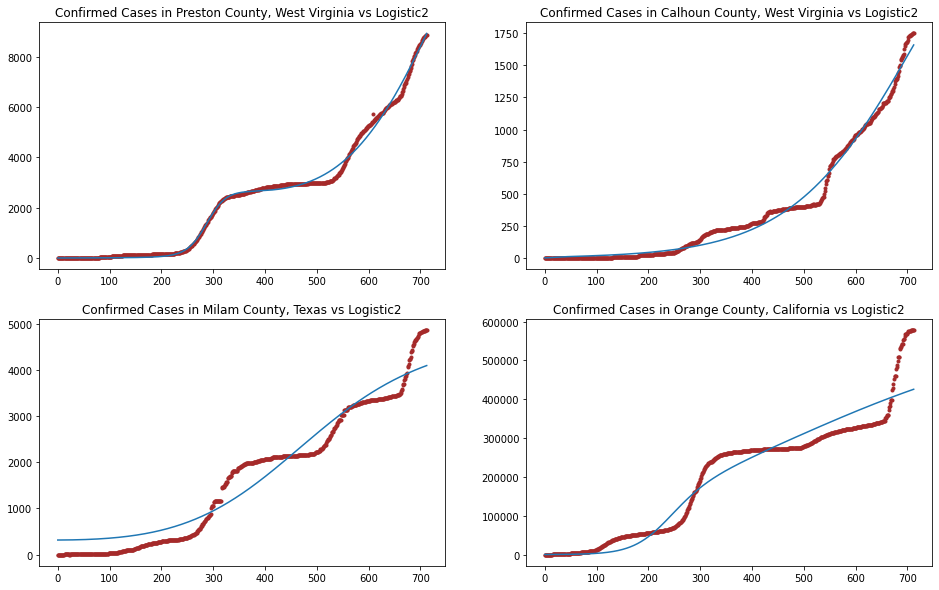

In [16]:
util.graph_examples(filtered, ts_col_name, {"Logistic2": log2_df})

# Save the curves

Save the coefficients of the curves we just fit to disk, so that [`analyze_fit_us_data.ipynb`](analyze_fit_us_data.ipynb)
can reconstruct the curves and compare them to the underlying time series.

In [17]:
# Stuff all the curves that we have fit into a single dataframe,
# along with the original series' values
curves_df = filtered[metadata_cols + [ts_col_name, outlier_col_name]].copy()
curves_df["Exponential"] = exp_df["Curve"]
curves_df["Logistic"] = log_df["Curve"]
curves_df["Logistic2"] = log2_df["Curve"]
curves_df

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 624.6331894752971, 628.6710725690873, 632....","[ 611.6209674664152, 613.4863366928142, 615...."
1003,Alabama,Baldwin,223234,319,9,"[ 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[2060.7612874244896, 2073.158727058375, 2085...","[1804.2584408744247, 1816.14563698272, 1828...."
1005,Alabama,Barbour,24686,20,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[1379.0803011728278, 1381.8282813341243, 1384....","[282.27595708244377, 283.68114620977803, 285...."
1007,Alabama,Bibb,22394,40,2,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[290.18903826648176, 291.8275900300823, 293.4...","[295.61514965040647, 297.1057910613274, 298.6..."
1009,Alabama,Blount,57826,116,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 595.9804081930149, 599.8802336825881, 603....","[164.62408247212932, 164.66464007153942, 164.7..."
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 2589.560912294687, 2594.633492819649, 2599...","[431.93541728442926, 432.6363961292781, 433...."
56039,Wyoming,Teton,23464,114,0,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 2078.609359356614, 2082.7091822119874, 2086...","[500.99717144243004, 503.45956478220455, 505.9..."
56041,Wyoming,Uinta,20226,30,0,"[ 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ 1.0, 1.0010005001667084, 1.002...","[ 220.8006252837378, 222.07899021650775, 223.3...","[ 349.5786645385999, 350.7172917108218, 351...."


In [18]:
# Expand out the tensors to multiple rows for writing to a CSV file, and
# cast the boolean values back to np.bool
curves_vertical = util.explode_time_series(curves_df, filtered_dates)
curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)
curves_vertical

/var/folders/bd/k5pyhn0130708d7y9q2pjj380000gn/T/ipykernel_26487/776648474.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  curves_vertical["Confirmed_Outlier"] = curves_vertical["Confirmed_Outlier"].astype(np.bool)


State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               124   
      2020-03-11  Alabama  Autauga       55869               124   
      2020-03-12  Alabama  Autauga       55869               124   
      2020-03-13  Alabama  Autauga       55869               124   
      2020-03-14  Alabama  Autauga       55869               124   
...                   ...      ...         ...               ...   
56045 2022-02-16  Wyoming   Weston        6927                 8   
      2022-02-17  Wyoming   Weston        6927                 8   
      2022-02-18  Wyoming   Weston        6927                 8   
      2022-02-19  Wyoming   Weston        6927                 8   
      2022-02-20  Wyoming   Weston        6927                 8   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              8          0              False     1.000000   
      2020-03-11              8          0              False     1.001001   
      2020-03-12              8          0              False     1.002002   
      2020-03-13              8          0              False     1.003005   
      2020-03-14              8          0              False     1.004008   
...                         ...        ...                ...          ...   
56045 2022-02-16              0       1530              False     2.029927   
      2022-02-17              0       1531              False     2.031958   
      2022-02-18              0       1532              False     2.033991   
      2022-02-19              0       1532              False     2.036026   
      2022-02-20              0       1532              False     2.038063   

                     Logistic    Logistic2  
FIPS  Date                                  
1001  2020-03-10   624.633189   611.620967  
      2020-03-11   628.671073   613.486337  
      2020-03-12   632.733923   615.374811  
      2020-03-13   636.821882   617.286631  
      2020-03-14   640.935088   619.222041  
...                       ...          ...  
56045 2022-02-16  1392.323000  1397.087344  
      2022-02-17  1394.800644  1399.646948  
      2022-02-18  1397.272091  1402.200724  
      2022-02-19  1399.737319  1404.748648  
      2022-02-20  1402.196306  1407.290695  

[2227412 rows x 10 columns]

In [19]:
# Write out the results to a CSV file plus a JSON file of type metadata.
counties_curves_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
curves_vertical.to_csv(counties_curves_csv_data_file, index=True)
col_type_mapping = {
    key: str(value) for key, value in curves_vertical.dtypes.iteritems()
}

counties_curves_json_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")
print(f"Writing curves to {counties_curves_json_data_file}")
with open(counties_curves_json_data_file, "w") as f:
    json.dump(col_type_mapping, f)

Writing curves to outputs/us_counties_curves_meta.json


In [20]:
# Combine all of the parameters of the curve into another dataframe and
# write that dataframe to a second CSV file.
params = filtered[metadata_cols].copy()
params["Exp_Rate"] = exp_df["Rate"]
params["Exp_Offset"] = exp_df["Offset"]

params["Log_Max"] = log_df["Max"]
params["Log_Rate"] = log_df["Rate"]
params["Log_Offset"] = log_df["Offset"]

params["Log2_Max1"] = log2_df["Max1"]
params["Log2_Rate1"] = log2_df["Rate1"]
params["Log2_Offset1"] = log2_df["Offset1"]
params["Log2_Max2"] = log2_df["Max2"]
params["Log2_Rate2"] = log2_df["Rate2"]
params["Log2_Offset2"] = log2_df["Offset2"]
params["Log2_Switch_Begin"] = log2_df["Switch_Begin"]
params["Log2_Switch_End"] = log2_df["Switch_End"]
params

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,124,8,0.001,0.000000e+00,15179.713386,0.006721,468.457363,987.876708,0.000000,7.710577,15913.608256,0.008568,261.268712,4.154896e+02,620.310606
1003,Alabama,Baldwin,223234,319,9,0.001,0.000000e+00,68013.984324,0.006186,560.283844,1256.197249,0.333574,175.942400,87773.004970,0.005892,515.197260,1.147566e+02,697.932161
1005,Alabama,Barbour,24686,20,3,0.001,0.000000e+00,2770.948678,0.003967,2.326799,764.872875,0.048021,195.885464,12191.283651,0.004235,709.476249,1.535955e+01,565.389535
1007,Alabama,Bibb,22394,40,2,0.001,0.000000e+00,7724.076583,0.005851,554.305266,941.978628,0.201391,267.594324,15293.994241,0.004501,712.999999,3.591289e-06,713.000000
1009,Alabama,Blount,57826,116,3,0.001,0.000000e+00,15085.899997,0.006791,469.858542,346.737471,0.000000,31.548526,17461.780921,0.030568,198.613055,5.162883e+02,713.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,120,3,0.001,0.000000e+00,5220.855522,0.003887,4.113539,984.190634,0.000000,28.932259,13629.048656,0.006375,562.737207,1.908834e-07,77.411895
56039,Wyoming,Teton,23464,114,0,0.001,0.000000e+00,4184.771657,0.003919,3.360202,973.292071,0.007752,49.628179,21915.907695,0.004985,713.000000,3.958240e+00,710.221965
56041,Wyoming,Uinta,20226,30,0,0.001,0.000000e+00,7384.003627,0.005951,584.638181,988.611704,0.004711,33.203244,7566.244902,0.006279,546.655389,1.502862e+01,360.753536


In [21]:
counties_curves_params_csv_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
print(f"Writing parameters of curves to {counties_curves_params_csv_data_file}.")
params.to_csv(counties_curves_params_csv_data_file, index=True)

Writing parameters of curves to outputs/us_counties_curves_params.csv.
